# dCG toy example problem
This notebook shows the implementation of the toy example problem for the paper 
[dCG - differentiable connected geometries for AI-compatible multi-domain optimization and inverse design](https://arxiv.org/abs/2410.05833)

There are 4 different sections in the notebook: 
  1. manual implementation of the dCG circles
  2. an object oriented implementation 
  3. optimization via gradient descent of the manual implementation 
  4. comparison of the GD optimization with the gradient-free downhill-simplex algorithm

In [15]:
import torch as th
import numpy as np
import os

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

This first section helps with the discretization of the boundary. The gradient of a linspace function is generally not well defined. In the sense of shape derivatives, it is equivalent to an integration of a scalar gradient field along the boundary. This implementation handles the boundary integration during the backward execution.

In [16]:
class BoundaryIntegrationPoints(th.autograd.Function):
    """
    Custom autograd function for computing a differentiable boundary discretization in 1D.

    Args:
        n (int): Number of discretization points.
        x0 (torch.Tensor): Starting point.
        x1 (torch.Tensor): Ending point.

    Returns:
        torch.Tensor, torch.Tensor: Tuple containing the x and y coordinates of support points.
    """

    @staticmethod
    def forward(ctx, n: int, x0: th.tensor, x1: th.tensor)->tuple[th.Tensor, th.Tensor]:
        """
        Computes the forward pass for support points.

        Args:
            ctx (torch.autograd.function._ContextMethodMixin): Context object.
            n (int): Number of support points.
            x0 (torch.Tensor): Starting point.
            x1 (torch.Tensor): Ending point.

        Returns:
            torch.Tensor, torch.Tensor: Tuple containing the x and y coordinates of support points.
        """
        # Save the number of discretization points and the delta between x1 and x0 in the context
        ctx.n = n
        dvecx = (x1 - x0) / n
        ctx.ds = th.linalg.norm(dvecx, dim=-1)
        # TODO: create support points with central differences
        # Compute the x and y coordinates of support points
        x_ = (th.linspace(1/(2*n), 1 - 1/(2*n), n) * (x1[0] - x0[0]) + x0[0]).unsqueeze(1)
        y_ = (th.linspace(1/(2*n), 1 - 1/(2*n), n) * (x1[1] - x0[1]) + x0[1]).unsqueeze(1)

        return x_, y_

    @staticmethod
    def backward(ctx, dx_, dy_):
        """
        Computes the backward pass for support points. This function is called by PyTorch's autograd engine.

        Note: Its ABSOLUTELY CRUCIAL that the gradients dx_ and dy_ are projected on the 
        normal direction of the line x - y BEFORE they're given to this backward. 
        Otherwise, the gradients will return non-zero tangential components which will 
        backpropagate and result in incorrect gradients on subsequent interfaces.

        Args:
            ctx (torch.autograd.function._ContextMethodMixin): Context object.
            dx_ (torch.Tensor): Gradient with respect to x_.
            dy_ (torch.Tensor): Gradient with respect to y_.

        Returns:
            None, torch.Tensor, torch.Tensor: Tuple containing gradients for x0 and x1.

        Info:
            Adding the normal projection is most easily done by registering a hook on the
            output of the boundary integration points. This hook should project the gradients
            onto the normal direction of the line x - y.
        """
        n = ctx.n
        ds = ctx.ds
        linear = th.linspace(1/(2*n),  1 - 1/(2*n), n)
        antilinear = th.linspace(1 - 1/(2*n), 1/(2*n), n)

        # this is an approximation of the integral along the line from x0 -> x1
        # we can approximate the integral with a sum and multiply with a constant
        # differential (equally spaced discretization points)
        dx0 = th.tensor(
            [
                th.sum(antilinear[:, None] * dx_) * ds, 
                th.sum(antilinear[:, None] * dy_) * ds
            ]
        )
        dx1 = th.tensor(
            [
                th.sum(linear[:, None] * dx_) * ds,
                th.sum(linear[:, None] * dy_) * ds
            ]
        )
        return None, dx0, dx1
    

def apply_boundary_integration_points(n, xi)->th.Tensor:
    """
    Discretizes the boundary of a 1D domain into n points.
    
    Args:
        n (int): Number of discretization points.
        xi (torch.Tensor): Boundary points.

    Returns:
        torch.Tensor: Discretized boundary.
    
    """
    out = []
    for x0, x1 in zip(xi[:-1], xi[1:]):
        x, y = BoundaryIntegrationPoints.apply(n, x0, x1)
        out.append(th.cat((x, y), dim=1))
    return th.cat(tuple(out), dim=0)

Next, we need a function that creates an instance of the circle given the origin and the radius. 

Furthermore we need a function which we can evaluate the geometry on. For this example, we will simply assume a static function. In a real physical optimization setting this function will be the direct solution from the adjoint method computed by the physical simulation. For more details, see our previous publication on the adjoint method with autograd and shape derivatives [Merging automatic differentiation and the adjoint method for photonic inverse design](https://iopscience.iop.org/article/10.1088/2632-2153/ad5411). 

In this example, computing of the adjoint solution is handled automatically by backpropagation. 

In [17]:
def circle(origin:th.Tensor, radius:th.Tensor, n:int = 100)->th.Tensor:
    '''
    Definition of a differentiable circle geometry surface.
    The discretization of the surface is fixed by choosing the number
    of surface points, but this is up to the user.

    Args:
        origin (torch.Tensor): Origin of the circle.
        radius (torch.Tensor): Radius of the circle.
        n (int): Number of discretization points.

    Returns:
        torch.Tensor: Discretized circle.

    '''
    x = radius * th.cos(th.linspace(0, 2*np.pi, n)) + origin[0]
    y = radius * th.sin(th.linspace(0, 2*np.pi, n)) + origin[1]

    return th.concatenate((x[:, None], y[:, None]), dim=1)

def f(x, y):
    return (th.cos(x) * th.sin(y))**2

### Section 1
Now we can proceed to initialize the connected geometry. We will do so manually to make this process clearer. Later, we will see a class which handles the geometry initialization and computation for free and restricted geometries.

In [18]:
def create_geometry(r_OA, r_OB, r_OC, radius_A, radius_B, radius_C):
    """
    Manual creation of the differntiable connected geometry via circles.

    Args:
        r_OA (torch.Tensor)->torch.Size([2]): Origin of circle A.
        r_OB (torch.Tensor)->torch.Size([2]): Origin of circle B. 
        r_OC (torch.Tensor)->torch.Size([2]): Origin of circle C.
        radius_A (torch.Tensor)->torch.Size([1]): Radius of circle A.
        radius_B (torch.Tensor)->torch.Size([1]): Radius of circle B.
        radius_C (torch.Tensor)->torch.Size([1]): Radius of circle C.

    Returns:
        (torch.Tensor)*10: Tuple containing the free boundaries of A, B, C, the origins of B and C, the normals of A, B, C, the restricted boundaries of B and
    
    """
    # Generation of the connected geometry
    r_OA.retain_grad()
    r_OB.retain_grad()
    r_OC.retain_grad()

    # Create the initial parent circle. Since we know that it has no parents, the free boundary is the same as the circle itself.
    A = A_free = circle(r_OA, radius_A).T
    # Create the child circles
    B = circle(r_OB, radius_B).T
    C = circle(r_OC, radius_C).T

    # We compute A/B for debugging purposes, its not necessary for the backpropagation in dCGs
    A_no_B = A[:, th.norm(A - r_OB[:,None], dim=0) > radius_B]

    # Separation of the connected geometry surface into free and restricted surfaces
    # For a circle, finding out which points are free can be done easily. 
    with th.no_grad():
        idx_B_free = th.norm(B - r_OA[:,None], dim=0) > radius_A
    B_free = B[:, idx_B_free]
    B_restricted = A[:, th.norm(A - r_OB[:,None], dim=0) < radius_B]
    # alternatively: B_restricted = B[:, ~idx_B_free]

    with th.no_grad():
        idx1 = th.norm(C - r_OA[:,None], dim=0) > radius_A
        idx2 = th.norm(C - r_OB[:,None], dim=0)
        idx_C_free = idx1*idx2 > radius_B
    C_free = C[:, idx_C_free]

    # Separation of the connected geometry surface into free and restricted surfaces
    # For debugging purposes, we compute the restricted surfaces of C by 
    # both of its parents independently and then concatenate them. 
    # Alternatively the restricted boundary is given by C[:, ~idx_C_free]
    C_restricted_of_A = A_no_B[:, th.norm(A_no_B - r_OC[:,None], dim=0) < radius_C]
    C_restricted_of_B = B_free[:, th.norm(B_free - r_OC[:,None], dim=0) < radius_C]
    C_restricted = th.cat((C_restricted_of_A, C_restricted_of_B), dim=1)

    # Finally, we compute the boundary normals which are necessary for the shape gradient 
    with th.no_grad():
        n_A = (A - r_OA[:, None])/th.norm(A - r_OA[:, None], dim=0)
        n_B = ((B - r_OB[:, None])/th.norm(B - r_OB[:, None], dim=0))[:, idx_B_free]
        n_C = ((C - r_OC[:, None])/th.norm(C - r_OC[:, None], dim=0))[:, idx_C_free]

    return A_free, B_free, C_free, r_OB, r_OC, n_A, n_B, n_C, B_restricted, C_restricted

# For the shape gradients to be correct, we need to project the gradients of the free 
# boundaries onto the normal direction of the boundary. This is done by modifying the 
# gradient of the free boundary in the backward pass by using a hook.
def boundary_normal_hook(normals):
    def hook(grad):
        grad = grad.clone()
        grad = th.einsum('ij,ij->j', grad, normals)[None, :] * normals
        return grad
    return hook

def apply_loss_function(A_free, B_free, C_free, n_A, n_B, n_C):
    A_free.register_hook(boundary_normal_hook(n_A))
    A_free.retain_grad()
    A_loss = f(A_free[0], A_free[1]).sum()
    
    B_free.register_hook(boundary_normal_hook(n_B))
    B_free.retain_grad()
    B_loss = f(B_free[0], B_free[1]).sum()
    
    C_free.register_hook(boundary_normal_hook(n_C))
    C_free.retain_grad()
    C_loss = f(C_free[0], C_free[1]).sum()
    
    loss = (A_loss + B_loss + C_loss)
    return loss

def plot_geometry(A_free, B_free, C_free, r_OA, r_OB, r_OC):

    xmin, xmax = -3.5, 2.
    ymin, ymax = -3.5, 4
    x, y = th.linspace(xmin, xmax, 1000), th.linspace(ymin, ymax, 1000)
    xx, yy = th.meshgrid(x, y, indexing='ij')
    zz = f(xx, yy)

    fig, ax = plt.subplots(1,1, dpi=150)
    cs = ax.imshow(zz.detach(), extent=[xmin, xmax, ymin, ymax])
    fig.colorbar(cs, location='left', pad=.15)

    ax.scatter(A_free[0].detach(), A_free[1].detach(), s=.3, label="Free boundary of A\nand gradients")
    ax.text(r_OA[0], r_OA[1] - .2, 'A')
    ax.scatter(B_free[0].detach(), B_free[1].detach(), s=.3, label = "Free boundary of B\nand gradients")
    ax.text(r_OB[0], r_OB[1] - .2, 'B')
    ax.scatter(C_free[0].detach(), C_free[1].detach(), s=.3, label="Free boundary of C\nand gradients")
    ax.text(r_OC[0], r_OC[1] - .2, 'C')

    scale = None

    # ax.plot([r_OA[0].detach(), (r_OA[0] + radius_A[0]).detach()], [r_OA[1].detach(), r_OA[1].detach()], linestyle = '--', label='radius A')
    # ax.plot([r_OB[0].detach(), (r_OB[0] + radius_B[0]).detach()], [r_OB[1].detach(), r_OB[1].detach()], linestyle = '--', label='radius B')
    # ax.plot([r_OC[0].detach(), (r_OC[0] + radius_C[0]).detach()], [r_OC[1].detach(), r_OC[1].detach()], linestyle = '--', label='radius C')

    ax.quiver(A_free[0].detach(), A_free[1].detach(), A_free.grad[0].detach(), A_free.grad[1].detach(), color='C0', scale=scale, scale_units='xy')
    ax.quiver(B_free[0].detach(), B_free[1].detach(), B_free.grad[0].detach(), B_free.grad[1].detach(), color='C1', scale=scale, scale_units='xy')
    ax.quiver(C_free[0].detach(), C_free[1].detach(), C_free.grad[0].detach(), C_free.grad[1].detach(), color='C2', scale=scale, scale_units='xy')

    # ax.scatter(B_restricted[0].detach(), B_restricted[1].detach(), c='firebrick', label="Restricted\nboundary of B")
    # ax.scatter(C_restricted[0].detach(), C_restricted[1].detach(), c='navy', label='Restricted\nboundary of C')

    ax.quiver(r_OA[0].detach(), r_OA[1].detach(), r_OA.grad[0].detach(), r_OA.grad[1].detach(), label=r"$r_{OA}$ gradient", color='C0', scale = scale, scale_units='xy')
    ax.quiver(r_OB[0].detach(), r_OB[1].detach(), r_OB.grad[0].detach(), r_OB.grad[1].detach(), label=r"$r_{OB}$ gradient", color='C1', scale = scale, scale_units='xy')
    ax.quiver(r_OC[0].detach(), r_OC[1].detach(), r_OC.grad[0].detach(), r_OC.grad[1].detach(), label=r"$r_{OC}$ gradient", color='C2', scale = scale, scale_units='xy')


    ax.scatter(0,0, marker='x', c='red', alpha = .7, label='Origin')
    ax.set_aspect('equal')
    ax.legend(bbox_to_anchor=(1, 1.05))
    plt.grid(linestyle='--', alpha = .3)
    plt.tight_layout(pad = 6., w_pad = 10., h_pad = .5)

    ax.set_xlabel('x [a.u.]')
    ax.set_ylabel('y [a.u.]')
    # ax.set_xlim(-3.7, 1.8)
    # ax.set_ylim(-1, 4.)
    ax.set_aspect('equal')
    # fig.savefig(os.getcwd() + '/plots/circles_gradient_field.pdf', dpi=250)
    # fig.savefig(os.getcwd() + '/plots/circles_gradient_field.png', dpi=250)

    # fig.savefig(os.getcwd() + '/plots/circles_gradient_field_title.pdf', dpi=250)
    # fig.savefig(os.getcwd() + '/plots/circles_gradient_field_title.png', dpi=250)

    return fig, ax 


### Section 2
Now that we have seen how the implementation works in principle, it becomes straightforward to turn it into a object oriented class. This makes handling the geometry much more intuitive. 

Logically, the entire boundary of the Circle is created upon initialization. Applying the geometry, ie. calling forward, is equivalent of computing the free- and restricted boundaries given all parents. 
In this example, forward for the individual geometries is explicitly called 


In [19]:
class Circle_dCG(th.nn.Module):
    """
    Implementation of a differentiable circle according to the dCG framework.

    Args:
        origin (torch.Tensor): Origin of the circle.
        radius (torch.Tensor): Radius of the circle.
        name (str): Name of the circle.

    Attributes:
        origin (torch.Tensor): Origin of the circle.
        radius (torch.Tensor): Radius of the circle.
        name (str): Name of the circle.
        boundary (torch.Tensor): Discretized boundary of the circle.
        free_boundary (torch.Tensor): Free boundary of the circle.
        restricted_boundary (torch.Tensor): Restricted boundary of the circle

    Example:
        >>> origin = th.tensor([0., 0.])
        >>> radius = th.tensor(1.)
        >>> circle = Circle(origin, radius, 'circle')
        >>> boundary = circle()
        >>> circle.plot_geometry()
        >>> plt.show()
    """

    def __init__(self, origin:th.Tensor, radius:th.Tensor, name:str):
        super().__init__()
        self.origin = origin
        self.radius = radius
        self.name = name

        boundary = circle(self.origin, self.radius)
        self.boundary = apply_boundary_integration_points(1, boundary)
        self.free_boundary = None
        self.restricted_boundary = None

    def forward(self, parents=[]):
        '''
        Returns the boundary of the circle as a 2xN tensor, where N is the number of points

        '''
        # if there are no parents, the free boundary is the entire boundary
        idx = th.ones_like(self.boundary[:, 0], dtype=bool)
        for p in parents:
            idx = idx & circle_difference_idx(self, p)

        n_hat = self._compute_boundary_normal()

        self.free_boundary = self.boundary[idx, :]
        self.free_boundary.retain_grad()
        self.free_boundary.register_hook(self._boundary_normal_hook(n_hat[idx, :]))

        # By definition, gradients are only computed for the free boundary
        with th.no_grad(): 
            self.restricted_boundary = self.boundary[~idx, :]
        
        return self.free_boundary
    
    def compute_free_and_restrict_boundary(self, parent):
        """
        Utility function to compute the free and restricted boundary attributes 
        of the circle with respect to a single parent circle.

        Args:
            parent (Circle): Parent circle.
        
        """
        idx = circle_difference_idx(self, parent)
        self.free_boundary = self.boundary[idx, :]
        self.restricted_boundary = self.boundary[~idx, :]
    

    def _compute_boundary_normal(self):
        with th.no_grad():
            n_hat = (self.boundary - self.origin[None, :])/th.norm(self.boundary - self.origin[None, :], dim=1)[:, None]
        return n_hat
    
    @staticmethod
    def _boundary_normal_hook(normals):
        def hook(grad):
            grad = grad.clone()
            grad = th.einsum('ij,ij->i', grad, normals)[:, None] * normals
            return grad
        return hook

    
    def __sub__(self, other):
        return circle_difference(self, other)
    
    
    def plot_geometry(self, ax, color = 'b', **kwargs):
        '''
        Plots the circle on a given axis

        '''
        ax.scatter(self.free_boundary[:, 0].detach(), self.free_boundary[:, 1].detach(), color=color, s=.3, label=f"Free boundary of {self.name} \nand gradients")
        ax.text(self.origin[0], self.origin[1] - .2, self.name, color=color)

    def plot_gradients(self, ax, color = 'b', **kwargs):
        '''
        Plots the gradients of the circle on a given axis

        '''
        x = self.free_boundary[:, 0].detach()
        y = self.free_boundary[:, 1].detach()

        dx = self.free_boundary.grad[:, 0].detach()
        dy = self.free_boundary.grad[:, 1].detach()

        ax.quiver(x, y, dx, dy, color=color, **kwargs)
    
 
def circle_difference(A:Circle_dCG, B:Circle_dCG):
    """
    Computes the set difference A/B between two circles A and B.

    """

    return A.boundary[th.norm(A.boundary - B.origin[None, :], dim=1) > B.radius, :]

def circle_difference_idx(A:Circle_dCG, B:Circle_dCG):
    """
    Computes the set difference A/B between two circles A and B and returns 
    a boolean mask for the boundary of A.

    """

    return th.norm(A.boundary - B.origin[None, :], dim=1) > B.radius


We can proceed to try the object oriented implementation and evaluate it on the function f:

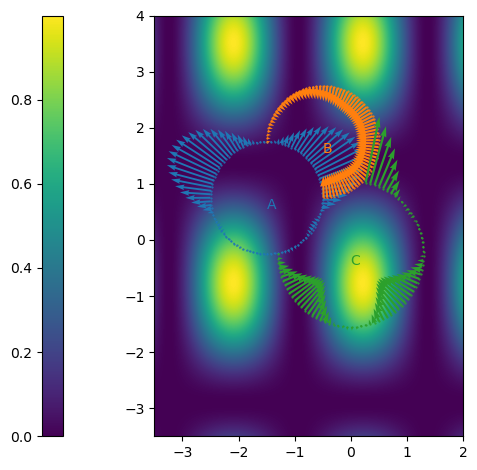

In [20]:
r_OA = th.tensor([-1.5, .75], requires_grad=True)
r_AB = th.tensor([1, 1.], requires_grad=True)
r_AC = th.tensor([1.5, -1.], requires_grad=True)
radius_A = th.tensor([1.], requires_grad=True)
radius_B = th.tensor([1.], requires_grad=True)
radius_C = th.tensor([1.3], requires_grad=True)


# Create the connected geometry
A = Circle_dCG(r_OA, radius_A, 'A')
B = Circle_dCG(r_OA + r_AB, radius_B, 'B')
C = Circle_dCG(r_OA + r_AC, radius_C, 'C')

# Compute the free and restricted boundaries
# This could be handled by a th.nn.Sequential module given the appropriate forward function
A_free = A([])
B_free = B([A])
C_free = C([A, B])

# Evaluate the free boundary on the function 
A_loss = f(A_free[:, 0], A_free[:, 1]).sum()
B_loss = f(B_free[:, 0], B_free[:, 1]).sum()
C_loss = f(C_free[:, 0], C_free[:, 1]).sum()

loss = (A_loss + B_loss + C_loss)

loss.backward()

fig, ax = plt.subplots(1,1) 
ax.set_aspect('equal')
xmin, xmax = -3.5, 2.
ymin, ymax = -3.5, 4
x, y = th.linspace(xmin, xmax, 1000), th.linspace(ymin, ymax, 1000)
xx, yy = th.meshgrid(x, y, indexing='ij')
zz = f(xx, yy)
cs = ax.imshow(zz.detach(), extent=[xmin, xmax, ymin, ymax])
fig.colorbar(cs, location='left', pad=.15)

A.plot_geometry(ax, color='C0')
B.plot_geometry(ax, color='C1')
C.plot_geometry(ax, color='C2')

A.plot_gradients(ax, color='C0', scale_units='xy')
B.plot_gradients(ax, color='C1', scale_units='xy')
C.plot_gradients(ax, color='C2', scale_units='xy')


### Section 3
We can start with the optimization now. We're using the explicit version of the geometry definition for the optimization loop. However, this would work very similarly by using the object oriented version of the circles and is the preferred way for more complicated problems. 

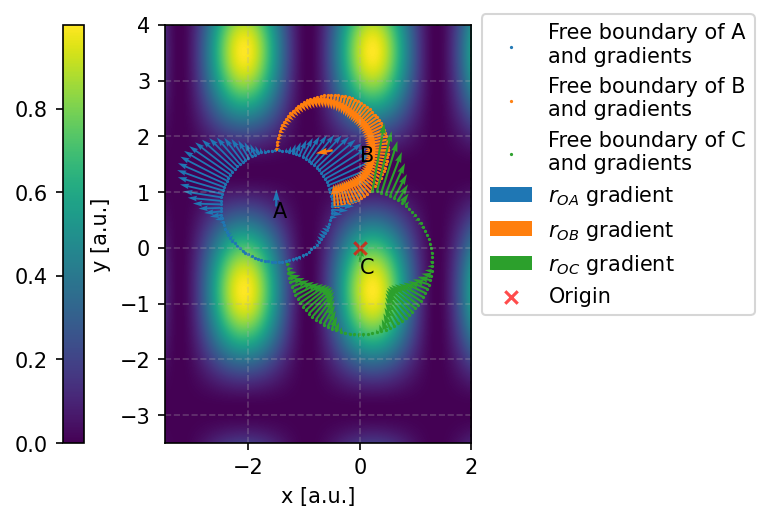

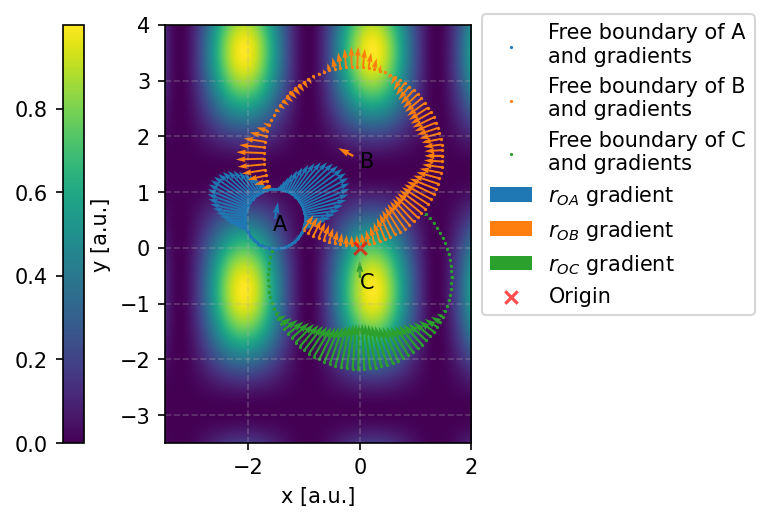

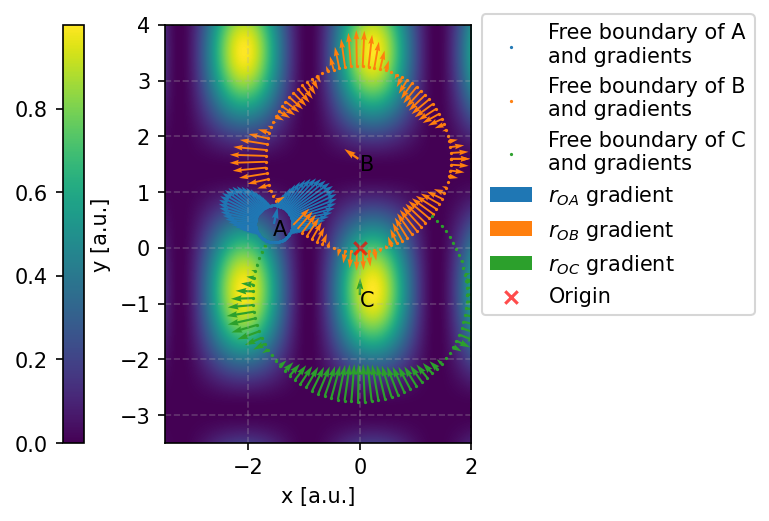

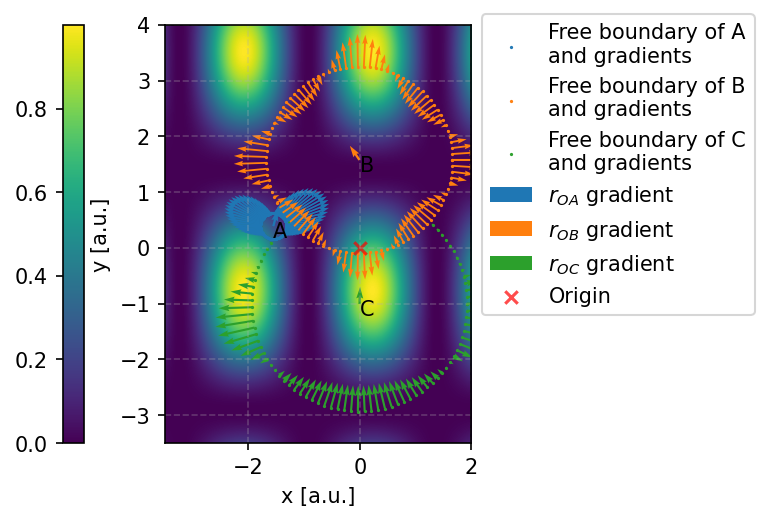

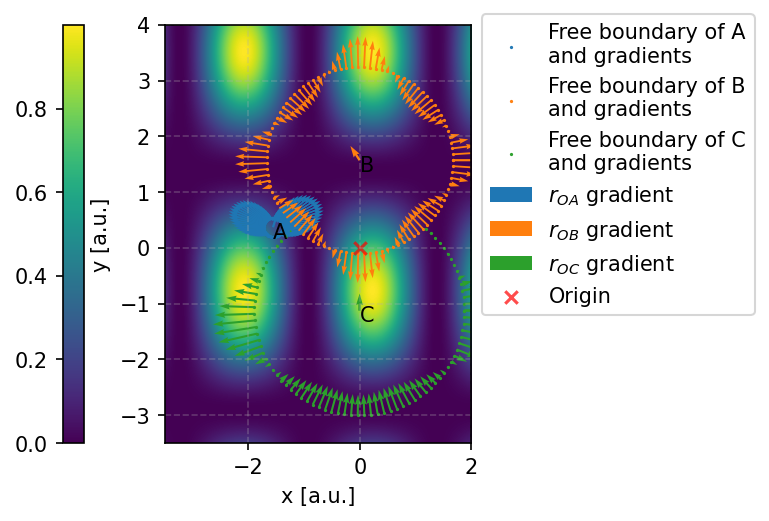

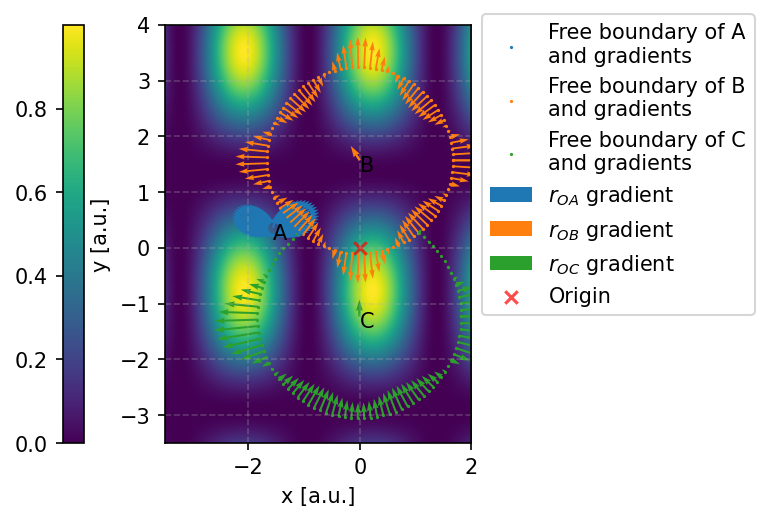

In [21]:
# Set of independent geometry parameters. The parameters are given to an optimizer to
# optimize the loss 

r_OA = th.tensor([-1.5, .75], requires_grad=True)
r_AB = th.tensor([-.5, 1.75], requires_grad=True)
r_AC = th.tensor([0, -.25], requires_grad=True)
radius_A = th.tensor([1.], requires_grad=True)
radius_B = th.tensor([1.], requires_grad=True)
radius_C = th.tensor([1.3], requires_grad=True)

optimizer = th.optim.SGD([r_OA, r_AB, r_AC, radius_A, radius_B, radius_C], lr=.0005)

losses = []

for i in range(201):
    optimizer.zero_grad()

    A_free, B_free, C_free, r_OB, r_OC, n_hat, n_B, n_C, B_restricted, C_restricted = create_geometry(r_OA, r_AB, r_AC, radius_A, radius_B, radius_C)
    l = apply_loss_function(A_free, B_free, C_free, n_hat, n_B, n_C)
    # print('Loss: ', l.item())
    losses.append(l.item())
    l.backward()
    optimizer.step()

    if (i%40 == 0): # and (i != 0):
        fig, ax = plot_geometry(A_free, B_free, C_free, r_OA, r_OB, r_OC)

        # fig.savefig(os.getcwd() + f'/plots/circles_gradient_field_iter{i}.pdf', dpi=250)
        # fig.savefig(os.getcwd() + f'/plots/circles_gradient_field_iter{i}.png', dpi=250)

We repeat the same optimization but with a higher learning rate

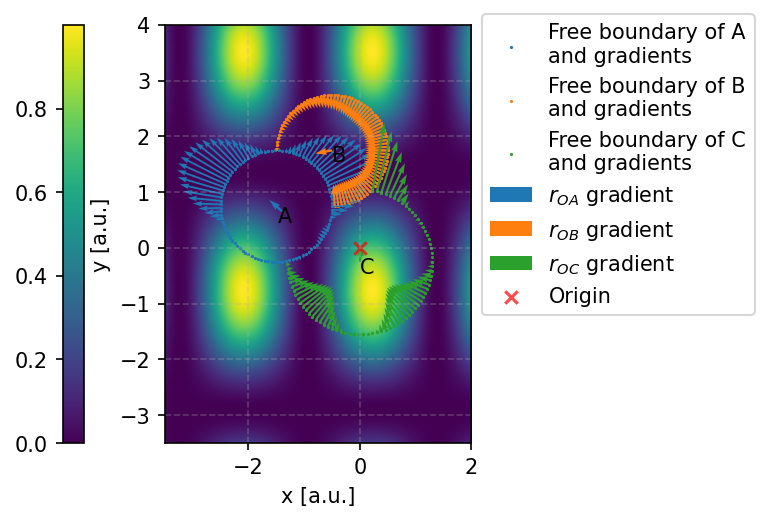

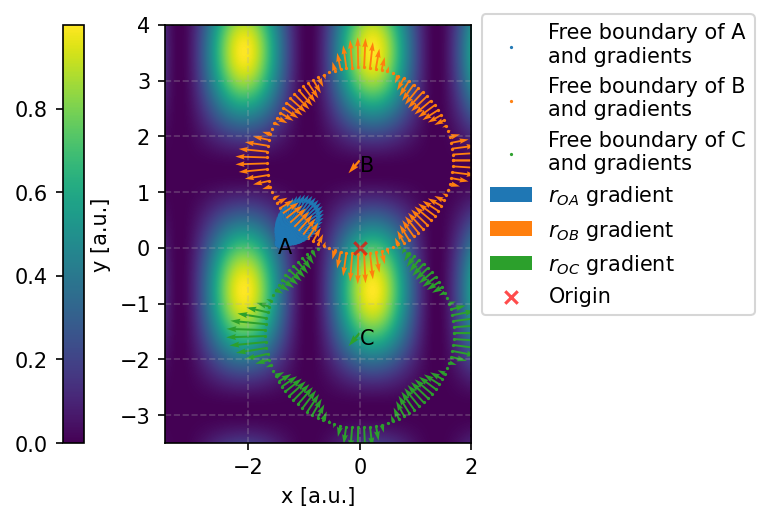

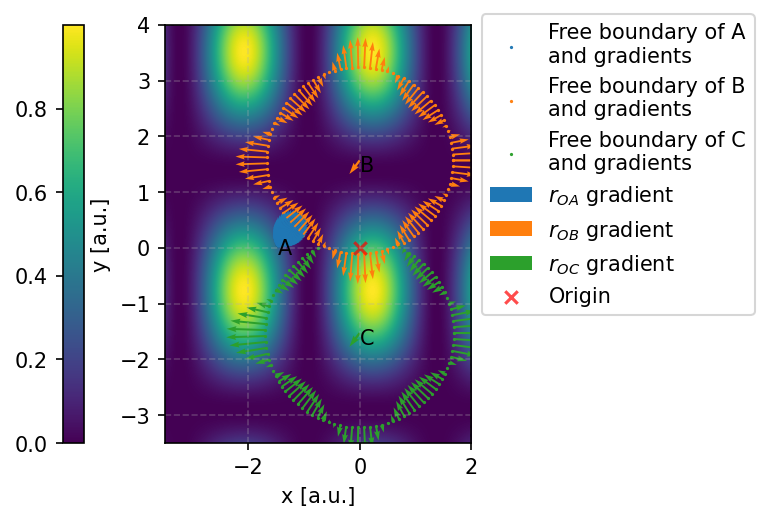

In [22]:
# higher learning rate 

r_OA = th.tensor([-1.5, .75], requires_grad=True)
r_AB = th.tensor([1., 1.], requires_grad=True)
r_AC = th.tensor([1.5, -1.], requires_grad=True)
radius_A = th.tensor([1.], requires_grad=True)
radius_B = th.tensor([1.], requires_grad=True)
radius_C = th.tensor([1.3], requires_grad=True)

optimizer = th.optim.SGD([r_OA, r_AB, r_AC, radius_A, radius_B, radius_C], lr=.005)

losses2 = []

for i in range(201):
    optimizer.zero_grad()
    r_OB = r_OA + r_AB
    r_OC = r_OA + r_AC
    A_free, B_free, C_free, _, _, n_hat, n_B, n_C, B_restricted, C_restricted = create_geometry(r_OA, r_OB, r_OC, radius_A, radius_B, radius_C)
    l = apply_loss_function(A_free, B_free, C_free, n_hat, n_B, n_C)
    # print('Loss: ', l.item())
    losses2.append(l.item())
    l.backward()
    optimizer.step()

    if (i%100 == 0): # and (i != 0):
        fig, ax = plot_geometry(A_free, B_free, C_free, r_OA, r_OB, r_OC)

        # fig.savefig(os.getcwd() + f'/plots/circles_gradient_field_iter{i}.pdf', dpi=250)
        # fig.savefig(os.getcwd() + f'/plots/circles_gradient_field_iter{i}.png', dpi=250)


Unsurprisingly, the optimization with higher learning rate converges much faster to the minimum. 

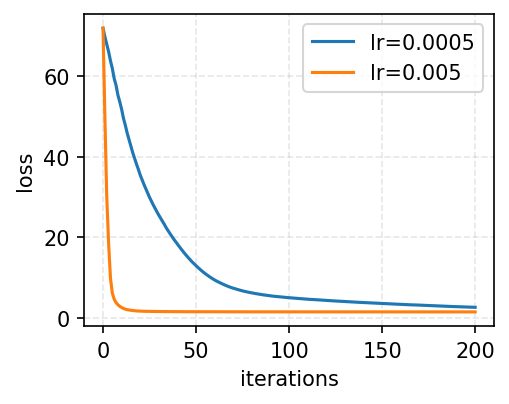

In [28]:
fig, ax = plt.subplots(1,1, figsize=(5*.7,4*.7), dpi=150)
ax.plot(losses, label='lr=0.0005')
ax.plot(losses2, label='lr=0.005')
ax.set_xlabel('iterations')
ax.set_ylabel('loss')
ax.grid(linestyle='--', alpha=.3)
ax.legend()

# fig.savefig(os.getcwd() + f'/plots/circles_gradient_field_loss.pdf', dpi=250)
# fig.savefig(os.getcwd() + f'/plots/circles_gradient_field_loss.png', dpi=250)

### Section 4
Comparison of the gradient descent optmization with the gradient-free downhill-simplex algorithm from Nelder and Mead. For this, we use the scipy implementation and need a new evaluation function since scipy works with numpy arrays and floats instead of torch tensors.

In [24]:
from scipy.optimize import minimize

# Set of dependent geometry parameters. The parameters are given to an optimizer to
# optimize the loss via scipy minimize.

r_OAx = -1.5
r_OAy = .75
r_ABx = 1.
r_ABy = 1.
r_ACx = 1.5
r_ACy = -1.
radius_A = 1.
radius_B = 1.
radius_C = 1.3


losses3 = []

# Define the evaluation function which is compatible with the scipy optimizer.
# Essentially, it is very similar to the gradient descent optimization loop above.

def eval(x):
    r_OAx, r_OAy, r_ABx, r_ABy, r_ACx, r_ACy, radius_A, radius_B, radius_C = x
    r_OA = th.tensor([r_OAx, r_OAy], requires_grad=True)
    r_AB = th.tensor([r_ABx, r_ABy], requires_grad=True)
    r_AC = th.tensor([r_ACx, r_ACy], requires_grad=True)
    radius_A = th.tensor([radius_A], requires_grad=True)
    radius_B = th.tensor([radius_B], requires_grad=True)
    radius_C = th.tensor([radius_C], requires_grad=True)

    r_OB = r_OA + r_AB
    r_OC = r_OA + r_AC
    A_free, B_free, C_free, _, _, n_A, n_B, n_C, B_restricted, C_restricted = create_geometry(r_OA, r_OB, r_OC, radius_A, radius_B, radius_C)
    l = apply_loss_function(A_free, B_free, C_free, n_A, n_B, n_C)
    losses3.append(l.item())
    return l.item()

# Run the downhill simplex algorithm
res = minimize(eval, x0=[r_OAx, r_OAy, r_ABx, r_ABy, r_ACx, r_ACy, radius_A, radius_B, radius_C], method='Nelder-Mead', options={"maxiter":203})


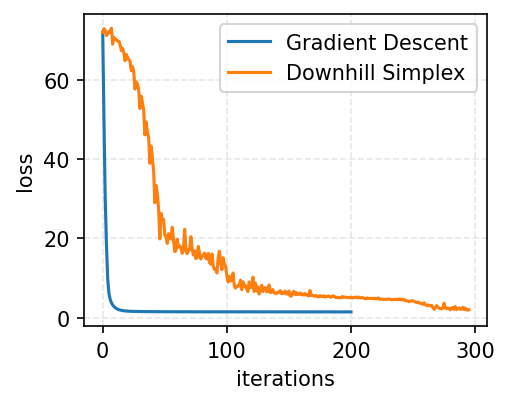

In [25]:
# Compare the gradient-free downhill simplex algorithm with gradient-based optimization

fig, ax = plt.subplots(1,1, figsize=(5*.7,4*.7), dpi=150)
ax.plot(losses2, label="Gradient Descent")
ax.plot(losses3, label="Downhill Simplex")
ax.set_xlabel('iterations')
ax.set_ylabel('loss')
ax.grid(linestyle='--', alpha=.3)
ax.legend()
# fig.savefig(os.getcwd() + f'/plots/circles_gradient_field_loss_GD_vs_DS.pdf', dpi=250)
# fig.savefig(os.getcwd() + f'/plots/circles_gradient_field_loss_GD_vs_DS.png', dpi=250)

Finally, lets visualize the solution found by the downhill simplex algorithm. It looks very similar to the one found by the gradient descent algorithm, with much more necessary optimization steps however.


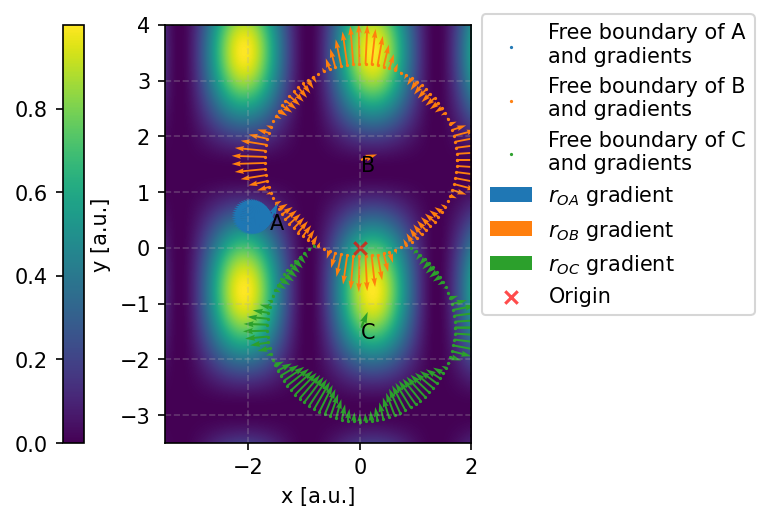

In [ ]:

r_OAx, r_OAy, r_ABx, r_ABy, r_ACx, r_ACy, radius_A, radius_B, radius_C = res.x

r_OA = th.tensor([r_OAx, r_OAy], requires_grad=True)
r_AB = th.tensor([r_ABx, r_ABy], requires_grad=True)
r_AC = th.tensor([r_ACx, r_ACy], requires_grad=True)
radius_A = th.tensor([radius_A], requires_grad=True)
radius_B = th.tensor([radius_B], requires_grad=True)
radius_C = th.tensor([radius_C], requires_grad=True)
r_OB = r_OA + r_AB
r_OC = r_OA + r_AC

A_free, B_free, C_free, _, _, n_hat, n_B, n_C, B_restricted, C_restricted = create_geometry(r_OA, r_OB, r_OC, radius_A, radius_B, radius_C)
l = apply_loss_function(A_free, B_free, C_free, n_hat, n_B, n_C)
l.backward()
fig, ax = plot_geometry(A_free, B_free, C_free, r_OA, r_OB, r_OC)